In [485]:
from sqlalchemy import create_engine
import pandas as pd
import matplotlib.pyplot as plt

In [486]:
def connect_db():
    db_user = "dev"
    db_passsword = "dev"
    db_host = "localhost"
    db_port = "5432" # map this port in docker-compose
    db_name = "importer-db"
    return create_engine(f"postgresql+psycopg2://{db_user}:{db_passsword}@{db_host}:{db_port}/{db_name}")

# pip install psycopg2
conn = connect_db()

In [528]:
# Helper functions

def query(file_name):
    query = ""
    with open(file_name) as file:
        query = file.read()
    return pd.read_sql_query(query, conn)


def write_to_csv(df, file_name, column_to_clean):
    df = df.copy()
    df[column_to_clean] = df[column_to_clean].str.replace(';', ',')
    df[column_to_clean] = df[column_to_clean].str.replace('\n', ' ')
    df.to_csv(file_name, sep=';')


### Run initial query against database and save to csv

In [488]:
_df = query('./query3.sql') # Edit query3.sql for time range
_df.head()

,id,start_date,notices,has_locations,type
0,hy-CUR-125844582,2019-10-09,,True,teaching-participation-lectures
1,hy-CUR-128537858,2019-09-13,,True,teaching-participation-lectures
2,hy-CUR-128617086,2019-10-29,,True,teaching-participation-lectures
3,hy-CUR-128631415,2020-03-09,,True,teaching-participation-lectures
4,hy-CUR-128660001,2019-10-28,,True,teaching-participation-lectures


In [529]:
df = _df.copy()
print(df.shape)
df.index = df['id']
df['date'] = pd.to_datetime(df['start_date'])
df = df.loc[df['date'] > '2020-01-01']
print(df.shape)
write_to_csv(df.drop(['start_date', 'id'], axis=1), './initial_data.csv', column_to_clean='notices')

(80938, 5)
(69456, 6)


### Find keywords in study event notices

Most of them might not be useful but still interesting

In [526]:
df['zoom'] = df['notices'].str.contains('zoom', case=False)
df['etä'] = df['notices'].str.contains(r'\setä', case=False)
df['remote'] = df['notices'].str.contains('remote', case=False)
df['lähi'] = df['notices'].str.contains(r'\slähi', case=False)
df['moodle'] = df['notices'].str.contains('moodle', case=False)
df['has_notices'] = df['notices'].str.len() > 3

df.head()

,id,start_date,notices,has_locations,type,date,zoom,etä,remote,lähi,moodle,has_notices
id,,,,,,,,,,,,
hy-CUR-128631415,hy-CUR-128631415,2020-03-09,,True,teaching-participation-lectures,2020-03-09,False,False,False,False,False,False
hy-CUR-128678193,hy-CUR-128678193,2020-06-03,,False,exam-exam,2020-06-03,False,False,False,False,False,False
hy-CUR-128691859,hy-CUR-128691859,2020-03-10,,True,teaching-participation-lectures,2020-03-10,False,False,False,False,False,False
hy-CUR-128752180,hy-CUR-128752180,2020-01-14,,True,teaching-participation-lectures,2020-01-14,False,False,False,False,False,False
hy-CUR-128764734,hy-CUR-128764734,2020-03-09,,True,teaching-participation-lectures,2020-03-09,False,False,False,False,False,False


In [527]:
df["etä"].sum()

135

In [ ]:
# convert start_date to date-type and drop unneeded columns
df = df.drop(['id', 'start_date', 'notices'], axis=1)

### Make some derivations

If course type is _teaching-participation-online_ or _exam-electronic_, it clearly is online.

If course does not have registered locations, or has the words 'zoom', 'etä', 'remote' or 'online' in it, it is quite likely online.

Those columns are computed and exported to _data1.csv_ along others.

In [ ]:

df['is_online_type'] = df['type'].str.match(r"teaching-participation-online|exam-electronic")

df['likely_online'] = ~df['has_locations'] | df['zoom'] | df['etä'] | df['remote'] | df['is_online_type']

write_to_csv(df, './data1.csv', 'type')
df.head()

,has_locations,type,date,zoom,etä,remote,lähi,moodle,has_notices,is_online_type,likely_online
id,,,,,,,,,,,
hy-CUR-128631415,True,teaching-participation-lectures,2020-03-09,False,False,False,False,False,False,False,False
hy-CUR-128678193,False,exam-exam,2020-06-03,False,False,False,False,False,False,False,True
hy-CUR-128691859,True,teaching-participation-lectures,2020-03-10,False,False,False,False,False,False,False,False
hy-CUR-128752180,True,teaching-participation-lectures,2020-01-14,False,False,False,False,False,False,False,False
hy-CUR-128764734,True,teaching-participation-lectures,2020-03-09,False,False,False,False,False,False,False,False


### Check out the frequency of each column

We can see that keywords occur quite rarely and only 10.7% of courses have notices. 7.66% of courses are specified as online/electronic type. Only about 60% of courses have locations. The end result is that 40% of courses were likely online in some way.

In [ ]:
df.drop('type', axis=1).mean() * 100

<ipython-input-515-1b69279e756e>:1: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  df.drop('type', axis=1).mean() * 100


has_locations     60.556323
zoom               0.505356
etä                0.194368
remote             0.187169
lähi               0.037434
moodle             0.310988
has_notices       10.708938
is_online_type     7.669604
likely_online     39.970629
dtype: float64

### Correlation matrix between columns

Just for fun

In [ ]:
df.corr()

,has_locations,zoom,etä,remote,lähi,moodle,has_notices,is_online_type,likely_online
has_locations,1.000000,0.001432,-0.005853,-0.010717,0.006480,0.003279,0.010558,-0.350470,-0.989055
zoom,0.001432,1.000000,0.259626,0.020402,0.166564,0.411739,0.205793,-0.014436,0.087339
etä,-0.005853,0.259626,1.000000,-0.001911,0.320219,0.414369,0.127428,-0.007805,0.054081
remote,-0.010717,0.020402,-0.001911,1.000000,-0.000838,-0.002419,0.125042,-0.012481,0.053068
lähi,0.006480,0.166564,0.320219,-0.000838,1.000000,0.293000,0.055878,-0.005577,0.022196
moodle,0.003279,0.411739,0.414369,-0.002419,0.293000,1.000000,0.161279,-0.012211,0.044693
has_notices,0.010558,0.205793,0.127428,0.125042,0.055878,0.161279,1.000000,-0.050122,0.017203
is_online_type,-0.350470,-0.014436,-0.007805,-0.012481,-0.005577,-0.012211,-0.050122,1.000000,0.353204
likely_online,-0.989055,0.087339,0.054081,0.053068,0.022196,0.044693,0.017203,0.353204,1.000000


### Graph the fraction of online courses every 6 months

At peak around Jan 2021, over 90% of organized courses were likely online. Now in the last 6 months, the same number is under 40%.

Please note that these are charts only rough approximates and are somewhat skewed by the 6 month bucketing.

<AxesSubplot:title={'center':'Fraction of courses likely having online aspects'}, xlabel='date'>

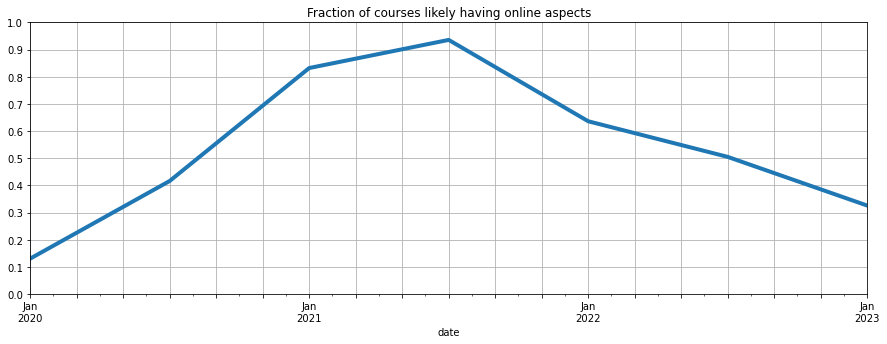

In [ ]:
is_teaching = df['type'].str.startswith('teaching')

monthly_teaching_df = df.copy()

monthly_teaching_df = monthly_teaching_df.loc[is_teaching].groupby(pd.Grouper(key="date", freq="6M")).mean()
xticks = pd.date_range(start=monthly_teaching_df.index[0], end=monthly_teaching_df.index[-1], freq='2M')
monthly_teaching_df['likely_online'].plot(
    figsize=(15, 5), grid=True, yticks=[x / 10 for x in range(0, 11)], xticks=xticks, linewidth=4,
    title="Fraction of courses likely having online aspects"
    )

### Graph the _absolute number_ of courses every 6 months

<AxesSubplot:title={'center':'Total count of courses VS courses with online aspects'}, xlabel='date', ylabel='Count'>

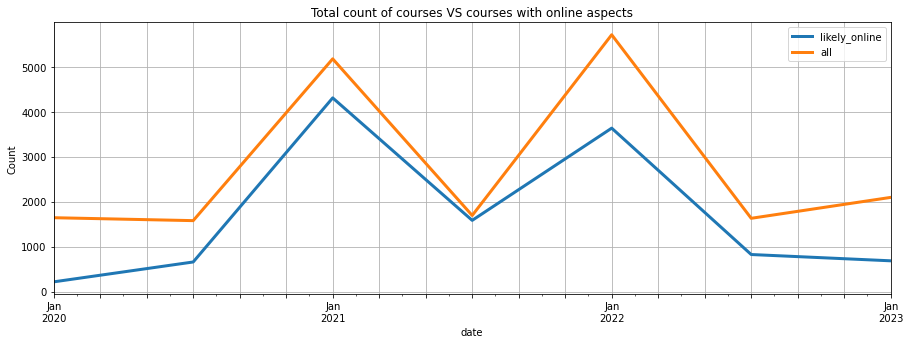

In [ ]:
monthly_teaching_df = df.copy()
monthly_teaching_df['all'] = True
monthly_teaching_df = monthly_teaching_df.loc[is_teaching].groupby(pd.Grouper(key="date", freq="6M")).sum()
monthly_teaching_df[['likely_online', 'all']].plot(
    figsize=(15, 5), grid=True, xticks=xticks, linewidth=3, ylabel="Count",
    title="Total count of courses VS courses with online aspects"
    )

### Graph the keyword counts

<AxesSubplot:title={'center':'Total number of courses with keywords in notices'}, xlabel='date', ylabel='Count'>

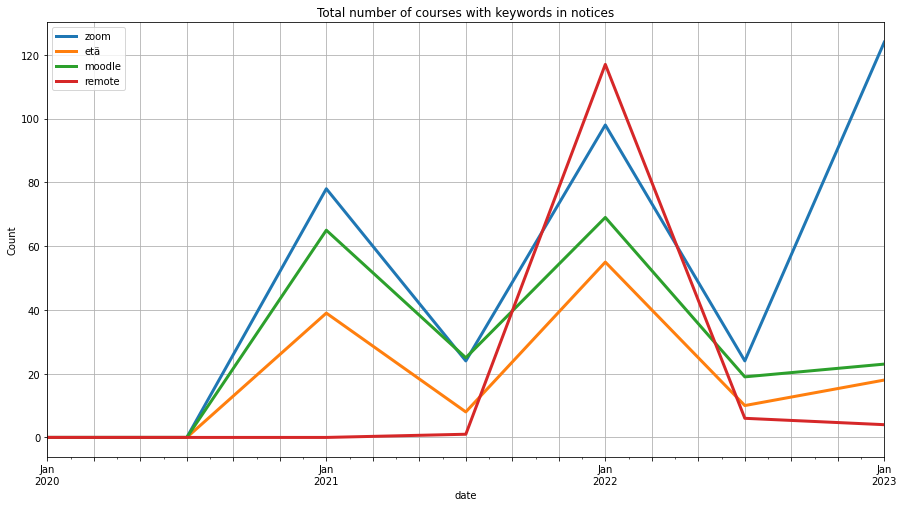

In [ ]:
monthly_teaching_df[['zoom', 'etä', 'moodle', 'remote']].plot(
    figsize=(15, 8), grid=True, xticks=xticks, linewidth=3, ylabel="Count", 
    title="Total number of courses with keywords in notices"
    )

<AxesSubplot:title={'center':'Fraction of teaching courses that have keywords in their study event notices'}, xlabel='date'>

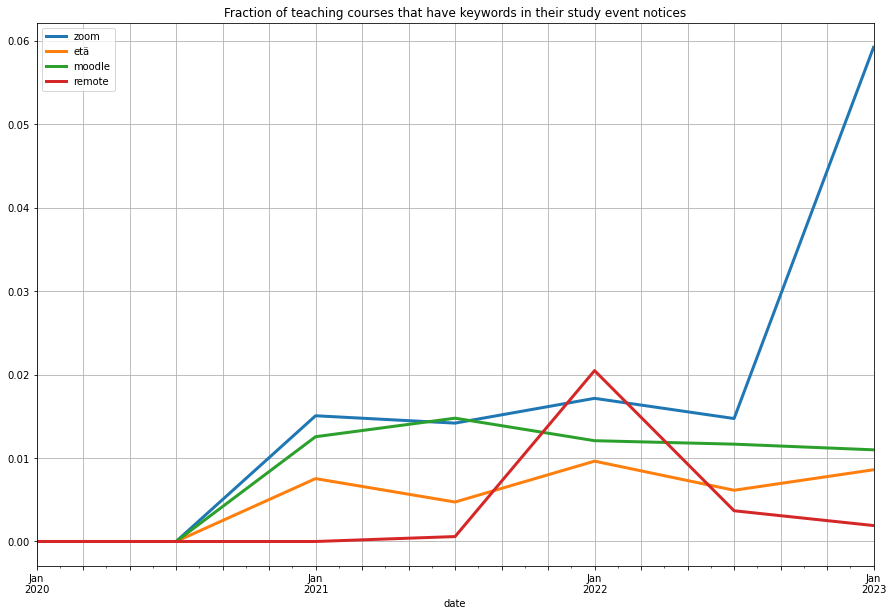

In [ ]:
monthly_teaching_df = df.copy()
monthly_teaching_df = monthly_teaching_df.loc[is_teaching].groupby(pd.Grouper(key="date", freq="6M")).mean()
monthly_teaching_df[['zoom', 'etä', 'moodle', 'remote']].plot(
    figsize=(15, 10), grid=True, xticks=xticks, linewidth=3, 
    title="Fraction of teaching courses that have keywords in their study event notices",
    )